In [48]:
from ibmm import EyeClassifier
from ibmm_online import EyeClassifierOnline
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import glob
import cv2
import os
from matplotlib import cm
from PIL import Image
from pathlib import Path
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
%matplotlib notebook

In [49]:
# Set start and end frame
start_frame = 600
end_frame = 700

# Read in ReticlePos
data = []
with open("tab55/tab55_reticle.txt","r") as f:
    next(f)
    data = f.readlines()

In [50]:
# Parse Data
x_vals = np.zeros(len(data))
y_vals = np.zeros(len(data))
frame_vals = np.zeros(len(data))

for i, line in enumerate(data):
    FrameSequence = re.findall(r"FrameSequence:\{\d+\}",line)
    ReticlePos = re.findall(r"ReticlePos:\{X\=[-]?\d+[.]?\d*[e]?[-]?\d* Y\=[-]?\d+[.]?\d*[e]?[-]?\d*\}",line)
    FrameSequence_vals = re.findall(r"\d+",FrameSequence[0])
    ReticlePos_vals = re.findall(r"[-]?\d+[.]?\d*[e]?[-]?\d*", ReticlePos[0])
    frame_vals[i] = int(FrameSequence_vals[0])
    x_vals[i] = float(ReticlePos_vals[0])
    y_vals[i] = float(ReticlePos_vals[1])


In [51]:
# Read in image files
# Take in frame number and make animation of [-5,5] second interval around specified frame
folder = "tab55"

frames = []
images = []

for image in os.listdir(folder):
    if (image.endswith(".jpg")):
        images.append(image)

images.sort()

# preallocate video array
# video = np.zeros()
# print(len(images))

for i,image in enumerate(images[start_frame:end_frame]):
    frames.append(cv2.imread(os.path.join(folder, image)))

In [52]:
video = np.array(frames, dtype="float")

In [53]:
%matplotlib inline
# np array with shape (frames, height, width, channels)

fig, ax = plt.subplots()

# Since the text file starts at frame 2, need to shift by 2
# Note: Cannot start with start_frame < 2
x = x_vals[start_frame-2:end_frame-2]
y = y_vals[start_frame-2:end_frame-2]
frames = frame_vals[start_frame-2: end_frame-2]

sc = ax.scatter(0,0,s=50)
framenum = ax.annotate(0, xy=(1000, 50))

im = plt.imshow(video[0]/np.amax(video[0]))

plt.close() # this is required to not display the generated image

def init():
    # Change BGR to RGB
    im2 = video[0].copy()/np.amax(video[0])
    im2[:, :, 0] = video[0][:, :, 2]/np.amax(video[0])
    im2[:, :, 2] = video[0][:, :, 0]/np.amax(video[0])
    im.set_data(im2)

def animate(i):
    # Change BGR to RGB
    
    im2 = video[i].copy()/np.amax(video[i])
    im2[:, :, 0] = video[i][:, :, 2]/np.amax(video[i])
    im2[:, :, 2] = video[i][:, :, 0]/np.amax(video[i])
    im.set_data(im2)
    
    # Setting reticle position
    sc.set_offsets(np.c_[x[i],y[i]])
    sc.set_color("orange")
    
    # Setting frame number
    framenum.set_text("Frame: "+str(int(frames[i])))
    
# Interval is in milliseconds
anim = animation.FuncAnimation(fig, animate, init_func=init, frames=video.shape[0],
                               interval=100)
HTML(anim.to_html5_video())

In [80]:
def generate_video(start_frame, end_frame):
    folder = "tab55"

    frames = []
    images = []

    for image in os.listdir(folder):
        if (image.endswith(".jpg")):
            images.append(image)

    images.sort()

    # preallocate video array
    # video = np.zeros()
    # print(len(images))

    for i,image in enumerate(images[start_frame:end_frame]):
        frames.append(cv2.imread(os.path.join(folder, image)))
    
    video = np.array(frames, dtype="float")
    
    %matplotlib inline
    fig, ax = plt.subplots()

    # Since the text file starts at frame 2, need to shift by 2
    # Note: Cannot start with start_frame < 2
    x = x_vals[start_frame-2:end_frame-2]
    y = y_vals[start_frame-2:end_frame-2]
    frames = frame_vals[start_frame-2: end_frame-2]

    sc = ax.scatter(0,0,s=50)
    framenum = ax.annotate(0, xy=(1000, 50))

    im = plt.imshow(video[0]/np.amax(video[0]))

    plt.close() # this is required to not display the generated image

    def init():
        # Change BGR to RGB
        im2 = video[0].copy()/np.amax(video[0])
        im2[:, :, 0] = video[0][:, :, 2]/np.amax(video[0])
        im2[:, :, 2] = video[0][:, :, 0]/np.amax(video[0])
        im.set_data(im2)

    def animate(i):
        # Change BGR to RGB

        im2 = video[i].copy()/np.amax(video[i])
        im2[:, :, 0] = video[i][:, :, 2]/np.amax(video[i])
        im2[:, :, 2] = video[i][:, :, 0]/np.amax(video[i])
        im.set_data(im2)
    
        # Setting reticle position
        sc.set_offsets(np.c_[x[i],y[i]])
        sc.set_color("orange")

        # Setting frame number
        framenum.set_text("Frame: "+str(int(frames[i])))
        framenum.set_color("yellow")

    # Interval is in milliseconds
    anim = animation.FuncAnimation(fig, animate, init_func=init, frames=end_frame-start_frame,
                                   interval=100)
    return(anim)

    

In [81]:
HTML(generate_video(450,500).to_html5_video())

In [7]:
from ibmm import EyeClassifier
# from ibmm_online import EyeClassifierOnline
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import cm

from parser_utils import read_periph_recording, parse_new_dreyevr_rec, GetGazeDeviationFromHead
from pathlib import Path
from tqdm import tqdm
import pickle as pkl

In [8]:
%matplotlib ipympl
%load_ext autoreload
%autoreload 2

In [9]:
path_to_recording = "tab55/tab55.txt"
# path_to_recording = "C://carla//carla.periph//RecordingTxts//esther//esther55.txt"
# path_to_recording = "C://carla//carla.periph//RecordingTxts//jacob/jacob55.txt"
# path_to_recording = "C://carla//carla.periph//RecordingTxts//george//george-55.txt"

recording_name = Path(path_to_recording).stem
recdf_pklname = Path("temp_data").joinpath(recording_name+".pkl")

In [10]:
df = parse_new_dreyevr_rec(path_to_recording, False)
df1 = df.copy()

100%|██████████| 5299/5299 [00:38<00:00, 137.86it/s]


In [13]:
# find the indices where lights came on and went off
lighton_rows = df1["LightOn"].diff().fillna(0)==1
lightoff_rows = df1["LightOn"].diff().fillna(0)==-1
df1[lighton_rows].head()
lighton_idcs = df1[lighton_rows].index
num_targets_spawned = sum(lighton_rows)
# find the indices where the button was pressed
buttonPress_rows = df1["ButtonPressed"].diff().fillna(0)==1
buttonRelease_rows = df1["ButtonPressed"].diff().fillna(0)==-1
num_button_presses = sum(buttonPress_rows)
print("{} targets spawned".format(num_targets_spawned))
print("{} responses recorded".format(num_button_presses)) # may or may not be all accurate responses that correspond to targets?

12 targets spawned
9 responses recorded


In [14]:
df2 = df1.copy()
df2['gaze_x'] = df1.GazeDir_COMBINED.apply(lambda x: x[0])
df2['gaze_y'] = df1.GazeDir_COMBINED.apply(lambda x: x[1])
df2['gaze_z'] = df1.GazeDir_COMBINED.apply(lambda x: x[2])

gaze_pitches = np.arctan2(df2.gaze_z, df2.gaze_x)*180/np.pi
gaze_yaws = np.arctan2(df2.gaze_y, df2.gaze_x)*180/np.pi

low_conf_gazeidcs = (gaze_pitches*gaze_yaws == 0)
gaze_pitches = gaze_pitches[~low_conf_gazeidcs]
gaze_yaws = gaze_yaws[~low_conf_gazeidcs]


print(np.min(gaze_pitches),np.max(gaze_pitches))
print(np.min(gaze_yaws),np.max(gaze_yaws))

-16.798371781305296 11.607415675794943
-29.645261313723815 38.33752289340374


<IPython.core.display.Javascript object>


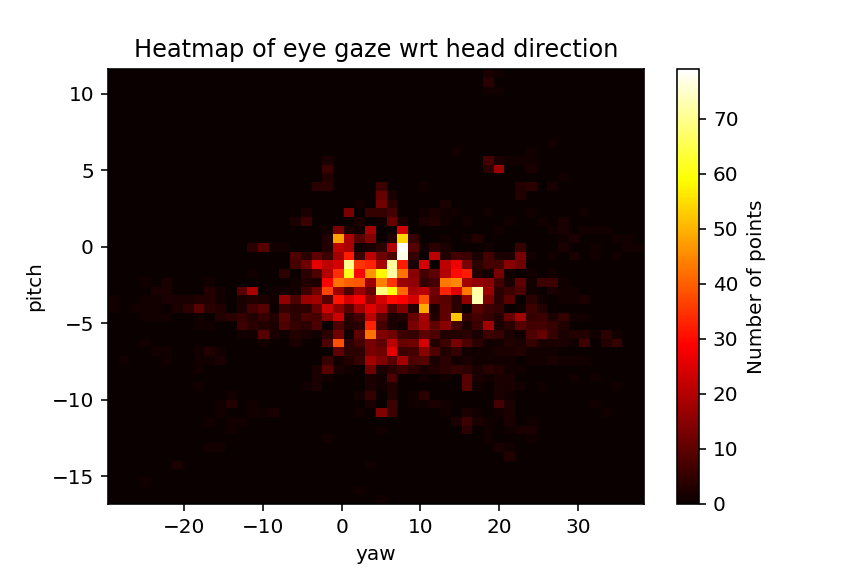

In [15]:
# Generate heat map of eye gaze wrt head pos
plt.figure()
plt.hist2d(gaze_yaws, gaze_pitches,
           bins=50, cmap='hot')
cb = plt.colorbar()
cb.set_label('Number of points')
plt.title('Heatmap of eye gaze wrt head direction')
# plt.xlim(-20,20)
# plt.ylim(-20,20)
plt.xlabel('yaw')
plt.ylabel('pitch')
plt.show()

In [16]:
max_reaction_time_allowed = 5 #seconds
time_offsets = []
hits_and_misses = []
for idx_num, lighton_idx in tqdm(enumerate(lighton_idcs)):
    # while not found_buttonpress or lighton_idcs[idx_num+1]:
    offset = 0
    target_tuple = (df1.loc[lighton_idx], False)
    while lighton_idx+offset < max(df1.index):
        time_offset = df1.loc[lighton_idx+offset, "TimeElapsed"] - df1.loc[lighton_idx, "TimeElapsed"]   
        if (df1.loc[lighton_idx+offset, "ButtonPressed"] == 1):
            # print("{0:1.2f}s".format(time_offset))
            time_offsets += [time_offset]
            target_tuple = (df1.loc[lighton_idx], df1.loc[lighton_idx+offset])
            break
        else:
            if time_offset > max_reaction_time_allowed:
                break
            offset += 1
    hits_and_misses += [target_tuple]
    
print("{}/{} hits with a {}s average reaction time".format(len(time_offsets), len(lighton_idcs), sum(time_offsets)/len(time_offsets)))

12it [00:00, 13.71it/s]

9/12 hits with a 0.6859911111111104s average reaction time


In [77]:
miss_frame = []
for tup in hits_and_misses:
    if type(tup[1]) == type(False):
        miss_frame.append(tup[0].name)

In [87]:
HTML(generate_video(miss_frame[0]-20,miss_frame[0]+20).to_html5_video())

In [89]:
HTML(generate_video(miss_frame[1]-20,miss_frame[1]+20).to_html5_video())

In [88]:
HTML(generate_video(miss_frame[2]-20,miss_frame[2]+20).to_html5_video())